# <span style="color:orange"> 2. MCP (Model Context Protocol) Servers and Clients
##### 
##### MCP is an 'USB-C' like to connect Any LLM with any Tools/Ressources/prompts Server 
##### 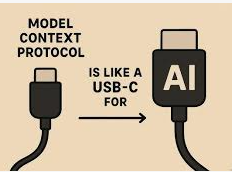

##### Quick start at https://modelcontextprotocol.io/introduction

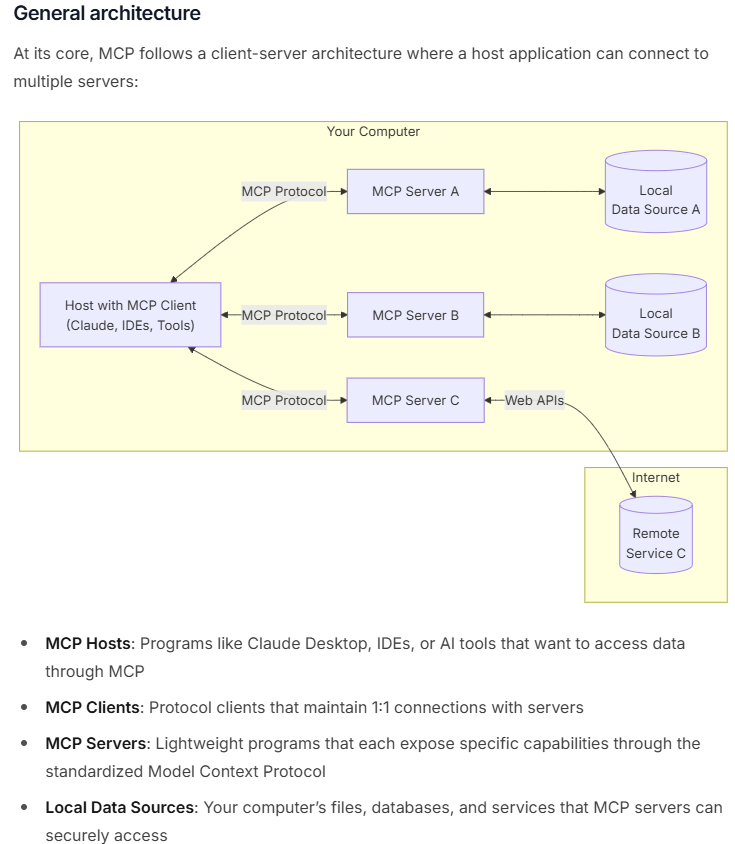


##### You can find MCP servers on 
##### https://github.com/modelcontextprotocol/servers
##### https://mcp.so/
##### ... 
##### For more deep dive :
##### https://huggingface.co/learn/mcp-course/unit0/introduction



## Improve LLMs with MCP Tools

#### Let's implement an MCP Client to connect our LLMs to external tools

#### <span style="color:orange"> NB : Yo can skip to n8n section if you will not implement your own MCP Clients , following code is for demonstration purpose , it aims to build an AI agent powered by MCP tools with few lines of code from scratch </span>


In [69]:
class MCPClient:
    
    def __init__(self):
        self.server_config = self.load_mcp_servers_config()
        self.process = None
        self.request_id = 0
        self.server_capabilities = None
    
    def load_mcp_servers_config(self):
        try:
            with open("mcp_servers.json", "r") as file:
                return json.load(file)
        except FileNotFoundError:
            return {
                'playwright': {
                    'command': 'npx',
                    'args': ['-y', '@executeautomation/playwright-mcp-server'],
                    'description': 'Tools for internet navigation'
                },
                'filesystem': {
                    'command': 'npx',
                    'args': ['-y', '@modelcontextprotocol/server-filesystem', '/tmp'],
                    'description': 'Tools for file system actions'
                },
                'github': {
                    'command': 'npx',
                    'args': ['-y', '@modelcontextprotocol/server-github'],
                    'env': {'GITHUB_PERSONAL_ACCESS_TOKEN': 'your_token_here'}
                }
            }
    
    async def start_server(self, server_name: str):
        config = self.server_config
        if "mcpServers" in config:
            config = config["mcpServers"]
        
        if server_name not in config:
            raise ValueError(f"Serveur {server_name} non trouvé dans la configuration")
    
        server_config = config[server_name]
        
        command = [server_config["command"]] + server_config["args"]
        env = os.environ.copy()
        if "env" in server_config:
            env.update(server_config["env"])
        
        print(f"▶️ Démarrage du serveur MCP: {' '.join(command)}")
        
        try:
            self.process = await asyncio.create_subprocess_exec(
                *command,
                stdin=asyncio.subprocess.PIPE,
                stdout=asyncio.subprocess.PIPE,
                stderr=asyncio.subprocess.PIPE,
                env=env
            )
            
            async def log_stderr():
                async for line in self.process.stderr:
                    print(f"   [MCP stderr]: {line.decode().strip()}", flush=True)
            asyncio.create_task(log_stderr())

            await asyncio.sleep(3) 
            if self.process.returncode is not None:
                raise RuntimeError(f"Le serveur {server_name} s'est arrêté prématurément avec le code {self.process.returncode}")

            print(f"✅ Serveur MCP '{server_name}' démarré (PID: {self.process.pid})")
            return self.process
        
        except Exception as e:
            print(f"❌ Échec du démarrage du serveur {server_name}: {e}")
            if self.process and self.process.returncode is None:
                self.process.terminate()
                await self.process.wait()
            raise
    
    async def send_request(self, method: str, params: Dict = None):
        if not self.process or self.process.returncode is not None:
            raise RuntimeError("Serveur MCP non démarré ou arrêté.")
        
        self.request_id += 1
        request = { "jsonrpc": "2.0", "id": self.request_id, "method": method, "params": params or {} }
        
        request_json = json.dumps(request) + "\n"
        self.process.stdin.write(request_json.encode())
        await self.process.stdin.drain()

        while True:
            try:
                response_line = await asyncio.wait_for(self.process.stdout.readline(), timeout=20.0)
                if not response_line: continue
                response_data = json.loads(response_line)
                if 'method' in response_data and response_data['method'].startswith('$/'): continue
                if 'id' in response_data and response_data['id'] == self.request_id: return response_data
            except asyncio.TimeoutError:
                print(f"⏰ Timeout en attente de la réponse pour la requête {self.request_id}")
                return {"jsonrpc": "2.0", "id": self.request_id, "error": {"code": -32603, "message": "Request timed out"}}
            except json.JSONDecodeError:
                print(f"⚠️ Erreur de décodage JSON pour la ligne: {response_line.decode()}")
                continue
    
    async def initialize(self):
        print("▶️ Initialisation du serveur MCP...")
        init_response = await self.send_request("initialize", {
            "protocolVersion": "2024-11-05", 
            "processId": os.getpid(),
            "clientInfo": {"name": "ImprovedAgentSystem", "version": "0.3"},
            "capabilities": {}
        })
        if "error" in init_response:
            raise RuntimeError(f"Échec de l'initialisation: {init_response['error']}")
        
        self.server_capabilities = init_response.get("result", {}).get("capabilities", {})
        print("✅ Serveur MCP initialisé avec succès.")
        await self.send_request("initialized")
        return init_response

    async def list_tools(self) -> List[Dict]: # CORRIGÉ : Retourne seulement la liste.
        print("🔍 Récupération de la liste des outils...")
        response = await self.send_request("tools/list")
        if "error" in response:
            raise RuntimeError(f"Échec de la récupération des outils: {response['error']}")
        tools = response.get("result", {}).get("tools", [])
        print(f"  -> Trouvé {len(tools)} outils.")
        return tools

    async def call_tool(self, tool_name: str, arguments: Dict) -> Dict:
        print(f"⚡️ Appel MCP: Outil='{tool_name}', Arguments={arguments}")
        response = await self.send_request("tools/call", {"name": tool_name, "arguments": arguments})
        if "error" in response:
            print(f"❌ Erreur lors de l'appel de l'outil: {response['error']}")
            return {"success": False, "error": response['error']}
        result = {"success": True, "result": response.get('result')}
        print(f"✔️ Réponse de l'outil: {json.dumps(result, indent=2, ensure_ascii=False)}")
        return result

    async def stop_server(self):
        if self.process and self.process.returncode is None:
            print("▶️ Arrêt du serveur MCP...")
            await self.send_request("shutdown")
            await self.send_request("exit")
            try: await asyncio.wait_for(self.process.wait(), timeout=5.0)
            except asyncio.TimeoutError: self.process.kill()
            print("✅ Serveur MCP arrêté.")
            self.process = None


#### Now we can start/connect to the MCP server , initialize it, ask for it's tools list or call a tool to get results

In [70]:
client = MCPClient()

In [71]:
await client.start_server('filesystem')

▶️ Démarrage du serveur MCP: npx -y @modelcontextprotocol/server-filesystem /tmp
   [MCP stderr]: Secure MCP Filesystem Server running on stdio
   [MCP stderr]: Allowed directories: [ '/tmp' ]
✅ Serveur MCP 'filesystem' démarré (PID: 66108)


<Process 66108>

In [72]:
await client.initialize()

▶️ Initialisation du serveur MCP...
✅ Serveur MCP initialisé avec succès.


{'result': {'protocolVersion': '2024-11-05',
  'capabilities': {'tools': {}},
  'serverInfo': {'name': 'secure-filesystem-server', 'version': '0.2.0'}},
 'jsonrpc': '2.0',
 'id': 1}

In [73]:
tools = await client.list_tools()

🔍 Récupération de la liste des outils...
  -> Trouvé 11 outils.


In [74]:
tools

[{'name': 'read_file',
  'description': 'Read the complete contents of a file from the file system. Handles various text encodings and provides detailed error messages if the file cannot be read. Use this tool when you need to examine the contents of a single file. Only works within allowed directories.',
  'inputSchema': {'type': 'object',
   'properties': {'path': {'type': 'string'}},
   'required': ['path'],
   'additionalProperties': False,
   '$schema': 'http://json-schema.org/draft-07/schema#'}},
 {'name': 'read_multiple_files',
  'description': "Read the contents of multiple files simultaneously. This is more efficient than reading files one by one when you need to analyze or compare multiple files. Each file's content is returned with its path as a reference. Failed reads for individual files won't stop the entire operation. Only works within allowed directories.",
  'inputSchema': {'type': 'object',
   'properties': {'paths': {'type': 'array', 'items': {'type': 'string'}}},
  

### <span style="color:magenta"> Building an STDIO MCP Server for Python Code Interpreter </span>

##### You can use any available open source MCP server for your needs, following sections wo MCP servers from scratch 
##### using both  STDIO and SSE (Server Send Event) approaches
##### This serevr expose a tool to run/execute python code (code interpreter)

In [ ]:
#!/usr/bin/env python3
"""
Serveur MCP simple pour exécuter du code Python
/path_to/mcp-python-executor/server.py
"""

import asyncio
import json
import sys
import subprocess
import tempfile
import os
from pathlib import Path
from typing import Any, Dict

# Configuration du serveur MCP
SERVER_INFO = {
    "name": "python-executor",
    "version": "1.0.0"
}

class MCPServer:
    def __init__(self):
        self.tools = {
            "execute_python": {
                "name": "execute_python",
                "description": "Exécute du code Python et retourne le résultat ou l'erreur",
                "inputSchema": {
                    "type": "object",
                    "properties": {
                        "code": {
                            "type": "string",
                            "description": "Le code Python à exécuter"
                        },
                        "timeout": {
                            "type": "number",
                            "description": "Timeout en secondes (défaut: 10)",
                            "default": 10
                        }
                    },
                    "required": ["code"]
                }
            }
        }

    async def handle_request(self, request: Dict[str, Any]) -> Dict[str, Any]:
        """Traite une requête MCP"""
        method = request.get("method")
        params = request.get("params", {})
        request_id = request.get("id")

        try:
            if method == "initialize":
                return {
                    "jsonrpc": "2.0",
                    "id": request_id,
                    "result": {
                        "protocolVersion": "2024-11-05",
                        "capabilities": {
                            "tools": {
                                "listChanged": False
                            }
                        },
                        "serverInfo": SERVER_INFO
                    }
                }

            elif method == "tools/list":
                return {
                    "jsonrpc": "2.0",
                    "id": request_id,
                    "result": {
                        "tools": list(self.tools.values())
                    }
                }

            elif method == "tools/call":
                tool_name = params.get("name")
                arguments = params.get("arguments", {})

                if tool_name == "execute_python":
                    result = await self.execute_python_code(
                         arguments.get("code", ""),
                        arguments.get("timeout", 10)
                    )
                    return {
                        "jsonrpc": "2.0",
                        "id": request_id,
                        "result": {
                            "content": [
                                {
                                    "type": "text",
                                    "text": result
                                }
                            ]
                        }
                    }
                else:
                    raise ValueError(f"Outil inconnu: {tool_name}")

            else:
                raise ValueError(f"Méthode non supportée: {method}")

        except Exception as e:
            return {
                "jsonrpc": "2.0",
                "id": request_id,
                "error": {
                    "code": -32603,
                    "message": str(e)
                }
            }

    async def execute_python_code(self, code: str, timeout: float = 10) -> str:
        """Exécute du code Python dans un environnement sécurisé"""
        if not code.strip():
            return "Erreur: Code vide"

        # Créer un fichier temporaire pour le code
        with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as f:
            f.write(code)
            temp_file = f.name

        try:
            # Exécuter le code Python
            process = await asyncio.create_subprocess_exec(
                sys.executable, temp_file,
                stdout=asyncio.subprocess.PIPE,
                stderr=asyncio.subprocess.PIPE
            )

            try:
                stdout, stderr = await asyncio.wait_for(
                    process.communicate(),
                    timeout=timeout
                )
            except asyncio.TimeoutError:
                process.kill()
                return f"Erreur: Timeout après {timeout} secondes"

            # Préparer le résultat
            result_parts = []

            if stdout:
                result_parts.append(f"Sortie:\n{stdout.decode('utf-8', errors='replace')}")

            if stderr:
                result_parts.append(f"Erreur:\n{stderr.decode('utf-8', errors='replace')}")

            if process.returncode != 0:
                result_parts.append(f"Code de sortie: {process.returncode}")

            if not result_parts:
                return "Exécution réussie (aucune sortie)"

            return "\n\n".join(result_parts)

        finally:
            # Nettoyer le fichier temporaire
            try:
                os.unlink(temp_file)
            except:
                 pass

    async def run(self):
        """Lance le serveur MCP"""
        while True:
            try:
                # Lire une ligne depuis stdin
                line = await asyncio.get_event_loop().run_in_executor(
                    None, sys.stdin.readline
                )

                if not line:
                    break

                # Parser la requête JSON-RPC
                try:
                    request = json.loads(line.strip())
                except json.JSONDecodeError:
                    continue

                # Traiter la requête
                response = await self.handle_request(request)

                # Envoyer la réponse
                print(json.dumps(response), flush=True)

            except Exception as e:
                # Envoyer une erreur générique
                error_response = {
                    "jsonrpc": "2.0",
                    "id": None,
                    "error": {
                        "code": -32603,
                        "message": f"Erreur serveur: {str(e)}"
                    }
                }
                print(json.dumps(error_response), flush=True)

async def main():
    """Point d'entrée principal"""
    server = MCPServer()
    await server.run()

if __name__ == "__main__":
    asyncio.run(main())


### <span style="color:magenta"> Building an SSE MCP Server for Browser Ops </span>

In [ ]:
"""MCP SSE Server Example with FastAPI /path_to/mcp-web/mcp-web.py"""
from pydantic import BaseModel
from fastapi import FastAPI
from fastmcp import FastMCP
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException, WebDriverException
from bs4 import BeautifulSoup
import logging
import time
import random
from threading import Lock

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Modèle pour la requête structurée
class NavigationRequest(BaseModel):
    url: str
    action: str = None  # "navigate", "type", "click", "scroll"
    selector: str = None  # CSS selector for actions
    value: str = None  # Value for type or scroll distance

# Modèle pour la réponse
class NavigationResult(BaseModel):
    title: str
    content_snippet: str
    url: str
    status: str

mcp: FastMCP = FastMCP("App")

# Gestion de l'instance Selenium
driver = None
driver_lock = Lock()

# Initialiser le driver
def initialize_driver():
    global driver
    if driver is None:
        hub_url = "http://localhost:4444/wd/hub"
        firefox_options = Options()
        firefox_options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:130.0) Gecko/20100101 Firefox/130.0")
        firefox_options.set_preference("dom.webdriver.enabled", False)
        firefox_options.set_preference("useAutomationExtension", False)
        try:
            driver = webdriver.Remote(command_executor=hub_url, options=firefox_options)
            driver.creation_time = time.time()  # Pour suivre l'inactivité
            logger.info("Selenium driver initialized successfully")
        except WebDriverException as e:
            logger.error(f"Failed to initialize driver: {e}")
            raise
    return driver

# Fermer le driver
def cleanup_driver():
    global driver
    with driver_lock:
        if driver:
            driver.quit()
            driver = None
            logger.info("Selenium driver closed")

# Navigate to url or perform actions
@mcp.tool()
async def navigate_to_url(input_data: str | dict) -> str:
    global driver
    with driver_lock:
        try:
            # Convertir l'entrée en NavigationRequest
            if isinstance(input_data, str):
                request = NavigationRequest(url=input_data)
            elif isinstance(input_data, dict):
                request = NavigationRequest(**input_data)
            else:
                raise ValueError("Input must be a string (URL) or a dictionary with 'url', 'action', etc.")

            logger.info(f"Received request: {request}")

            # Initialiser le driver si nécessaire
            if driver is None:
                initialize_driver()

            # Exécuter l'action demandée
            if request.action == "navigate" or request.action is None:
                driver.get(request.url)
                WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
                logger.info(f"Navigated to {request.url}")
                # Simuler un comportement humain
                driver.execute_script("window.scrollBy(0, 500);")
                time.sleep(random.uniform(1, 3))
                driver.execute_script("window.scrollBy(0, -200);")
                time.sleep(random.uniform(0.5, 2))

            # Détecter et gérer le CAPTCHA
            try:
                captcha = driver.find_element(By.ID, "recaptcha")
                logger.warning("CAPTCHA detected, waiting for manual resolution via VNC")
                time.sleep(30)  # Attendre l'intervention humaine
                WebDriverWait(driver, 60).until_not(
                    EC.presence_of_element_located((By.ID, "recaptcha"))
                )
                logger.info("CAPTCHA resolved, continuing")
            except NoSuchElementException:
                logger.info("No CAPTCHA detected")

            # Gérer les actions supplémentaires
            if request.action == "type":
                element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, request.selector)))
                element.clear()
                element.send_keys(request.value)
                logger.info(f"Typed '{request.value}' into {request.selector}")
            elif request.action == "click":
                element = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, request.selector)))
                element.click()
                logger.info(f"Clicked on {request.selector}")
            elif request.action == "scroll":
                driver.execute_script(f"window.scrollBy(0, {request.value});")
                logger.info(f"Scrolled by {request.value} pixels")

            # Attendre le rendu
            time.sleep(5)

            # Gérer les pop-ups de cookies
            try:
                cookie_buttons = [
                    'button[id*="accept"], button[class*="accept"], button[id*="consent"], button[class*="consent"]',
                    'button[id*="agree"], button[class*="agree"]',
                    'button[id*="ok"], button[class*="ok"]',
                    'button[id*="autoriser"], button[class*="autoriser"]',
                    'button[id*="accepter"], button[class*="accepter"]',
                    'button:contains("Accept"), button:contains("Agree"), button:contains("OK"), button:contains("Consent"), button:contains("Accepter"), button:contains("J\'accepte"), button:contains("Autoriser")',
                    '[role="button"][aria-label*="accept"], [role="button"][aria-label*="consent"]'
                ]
                for selector in cookie_buttons:
                    try:
                        buttons = driver.find_elements(By.CSS_SELECTOR, selector)
                        for button in buttons:
                            if button.is_displayed():
                                text = button.text.lower()
                                if any(keyword in text for keyword in ['accept', 'agree', 'ok', 'consent', 'accepter', 'autoriser']):
                                    button.click()
                                    logger.info(f"Clicked cookie pop-up button: {text}")
                                    time.sleep(1.5)
                                    break
                        else:
                            continue
                        break
                    except NoSuchElementException:
                        continue
                else:
                    logger.info("No cookie pop-up detected")
            except Exception as e:
                logger.info(f"Error handling cookie pop-up: {e}")

            # Extraire le contenu
            title = driver.title
            html_content = driver.page_source
            soup = BeautifulSoup(html_content, 'html.parser')
            for element in soup(['script', 'style', 'iframe', 'nav', 'footer', 'aside', '[class*="ad"], [id*="ad"]']):
                element.decompose()
            content_elements = soup.find_all(['p', 'h1', 'h2', 'h3', 'div', 'span', 'li', 'article', 'section'],
                                          class_=lambda x: x and not any(keyword in x.lower() for keyword in ['ad', 'advert', 'banner', 'promo']))
            text_parts = [element.get_text(separator=' ', strip=True) for element in content_elements if element.get_text(strip=True) and len(element.get_text().split()) > 5]
            content = ' '.join(text_parts) if text_parts else soup.get_text(separator=' ', strip=True)
            content = ' '.join(content.split())
            if "unusual traffic" in content.lower():
                logger.warning("Page blocked by CAPTCHA or traffic detection")
                return f"Failed to extract content due to CAPTCHA or traffic block\nURL: {request.url}"

            logger.info(f"Extracted content length: {len(content)} characters")
            driver.save_screenshot("/home/seluser/output/screenshot.png")
            logger.info("Screenshot saved to /home/seluser/output/screenshot.png")

            result = NavigationResult(title=title, content_snippet=content, url=request.url, status="success")
            return f"Page Title: {result.title}\nContent: {result.content_snippet}\nURL: {result.url}\nStatus: {result.status}"

        except Exception as e:
            logger.error(f"Error processing {request.url}: {e}")
            result = NavigationResult(title="", content_snippet="", url=request.url, status="error")
            return f"Failed to process {request.url}: {str(e)}\nStatus: {result.status}"

        finally:
            pass

# Outil pour fermer le navigateur manuellement
@mcp.tool()
async def close_browser() -> str:
    global driver
    with driver_lock:
        cleanup_driver()
        return "Browser closed successfully"

# Create FastAPI app and mount the SSE MCP server
app = FastAPI()
app.mount("/", mcp.sse_app())




In [ ]:
# To run the server
cd /path_to/mcp-web/
uv run uvicorn mcp-web:app --host 0.0.0.0 --port 8001 --reload

# The server is now available on http://localhost:8001/sse